https://machinelearningmastery.com/cnn-models-for-human-activity-recognition-time-series-classification/

In [146]:
import numpy as np
import pandas as pd
from tensorflow import keras
import matplotlib.pyplot as plt

In [65]:
%cd /media/ali/Ali/Projects/Machine_learning/1D\ CNN/'UCI HAR Dataset/'
%cd 'UCI HAR Dataset/'
%ls

/media/ali/Ali/Projects/Machine_learning/1D CNN/UCI HAR Dataset
/media/ali/Ali/Projects/Machine_learning/1D CNN/UCI HAR Dataset/UCI HAR Dataset
activity_labels.txt*  features.txt*  test/
features_info.txt*    README.txt*    train/


In [59]:
import numpy as np
import pandas as pd
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

In [66]:
load_file('test/Inertial Signals/body_acc_x_test.txt')

array([[ 0.01165315,  0.01310909,  0.01126885, ...,  0.00129151,
         0.00147   ,  0.00257384],
       [ 0.00927963,  0.00492971,  0.0039536 , ...,  0.0077876 ,
         0.00343349, -0.00123868],
       [ 0.00573194,  0.00706565,  0.00510976, ..., -0.00074285,
        -0.00192336, -0.00430462],
       ...,
       [-0.1476465 , -0.1699026 , -0.168698  , ...,  0.497893  ,
         0.2141275 , -0.1145089 ],
       [ 0.07122683, -0.0886653 , -0.07067473, ...,  0.1859878 ,
         0.2737114 ,  0.3536738 ],
       [-0.1936425 , -0.06498738, -0.0971221 , ..., -0.05075521,
        -0.01980675, -0.01104015]])

In [71]:
#  load a list of file into a 3D array of [samples, timesteps, features]
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    loaded = np.dstack(loaded)
    return loaded

In [74]:
files = ['body_acc_x_test.txt','body_acc_y_test.txt',
        'body_acc_z_test.txt']
data = load_group(files,
           'test/Inertial Signals/')

data.shape

(2947, 128, 3)

this 3D matrix (2947, 128, 3) means that we have 2947 events (or samples) each have 128 feauters. the 3 indicates the data type (for example body_acc_x_test))

In [61]:
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

keras.utils.to_categorical will make the one hot targets.
to see the difference you can comapre the output of those two

In [98]:
X, y = load_dataset_group('test')
yc = keras.utils.to_categorical(y)

In [100]:
print(y)
print(yc)
yc.shape

[[5]
 [5]
 [5]
 ...
 [2]
 [2]
 [2]]
[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


(2947, 7)

In [119]:
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train')
    print(trainX.shape, trainy.shape)
    # load all test
    testX, testy = load_dataset_group('test')
    print(testX.shape, testy.shape)
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = keras.utils.to_categorical(trainy)
    testy = keras.utils.to_categorical(testy)
    print(trainX.shape, trainy.shape, testX.shape, testy.shape)
    return trainX, trainy, testX, testy

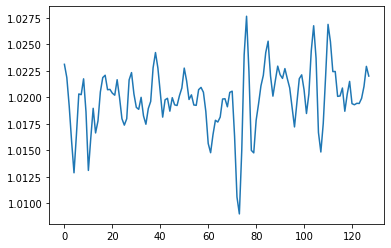

In [151]:
plt.plot(trainX[2][:,0])
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]

In [123]:
from keras.models import Sequential
from keras.layers import Conv1D, Dropout, MaxPool1D, Flatten, Dense

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [134]:
def evaluate_model(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 0, 10, 32
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size)
    _, accuracy = model.evaluate(testX, testy, batch_size=10)
    return accuracy

In [129]:
model.fit(trainX, trainy, epochs=10, batch_size=32)

Epoch 1/10
7352/7352 [==============================] - 4s 561us/step - loss: 0.3959 - acc: 0.8424
Epoch 2/10
7352/7352 [==============================] - 4s 500us/step - loss: 0.1430 - acc: 0.9419
Epoch 3/10
7352/7352 [==============================] - 4s 513us/step - loss: 0.1271 - acc: 0.9460
Epoch 4/10
7352/7352 [==============================] - 4s 500us/step - loss: 0.1109 - acc: 0.9529
Epoch 5/10
7352/7352 [==============================] - 4s 532us/step - loss: 0.0984 - acc: 0.9573
Epoch 6/10
7352/7352 [==============================] - 4s 501us/step - loss: 0.0970 - acc: 0.9551
Epoch 7/10
7352/7352 [==============================] - 4s 507us/step - loss: 0.1175 - acc: 0.9529
Epoch 8/10
7352/7352 [==============================] - 4s 543us/step - loss: 0.1001 - acc: 0.9561
Epoch 9/10
7352/7352 [==============================] - 4s 519us/step - loss: 0.0825 - acc: 0.9614
Epoch 10/10
7352/7352 [==============================] - 4s 514us/step - loss: 0.0808 - acc: 0.9625


In [133]:
_, accuracy = model.evaluate(testX, testy, batch_size=10)
print(accuracy)

2947/2947 [==============================] - 1s 187us/step
0.9022734978258063


In [136]:
scores = list()
repeats = 10
for r in range(repeats):
    score = evaluate_model(trainX, trainy, testX, testy)
    score = score * 100
    print('>#%d: %.3f' % (r+1, score))
    scores.append(score)

Epoch 1/10
7352/7352 [==============================] - 4s 579us/step - loss: 0.3971 - acc: 0.8414
Epoch 2/10
7352/7352 [==============================] - 4s 507us/step - loss: 0.1400 - acc: 0.9446
Epoch 3/10
7352/7352 [==============================] - 4s 507us/step - loss: 0.1210 - acc: 0.9504
Epoch 4/10
7352/7352 [==============================] - 4s 531us/step - loss: 0.1170 - acc: 0.9533
Epoch 5/10
7352/7352 [==============================] - 4s 525us/step - loss: 0.1016 - acc: 0.9572
Epoch 6/10
7352/7352 [==============================] - 4s 509us/step - loss: 0.1004 - acc: 0.9559
Epoch 7/10
7352/7352 [==============================] - 4s 517us/step - loss: 0.0998 - acc: 0.9558
Epoch 8/10
7352/7352 [==============================] - 4s 523us/step - loss: 0.1121 - acc: 0.9551
Epoch 9/10
7352/7352 [==============================] - 4s 521us/step - loss: 0.0971 - acc: 0.9580
Epoch 10/10
2947/2947 [==============================] - 1s 234us/step
>#1: 91.415
Epoch 1/10
7352/7352 [====

7352/7352 [==============================] - 3s 470us/step - loss: 0.0848 - acc: 0.9608
Epoch 9/10
7352/7352 [==============================] - 3s 466us/step - loss: 0.0758 - acc: 0.9652
Epoch 10/10
2947/2947 [==============================] - 1s 293us/step
>#8: 92.263
Epoch 1/10
7352/7352 [==============================] - 4s 594us/step - loss: 0.3933 - acc: 0.8414
Epoch 2/10
7352/7352 [==============================] - 3s 472us/step - loss: 0.1646 - acc: 0.9365
Epoch 3/10
7352/7352 [==============================] - 4s 491us/step - loss: 0.1230 - acc: 0.9499
Epoch 4/10
7352/7352 [==============================] - 3s 473us/step - loss: 0.1108 - acc: 0.9548
Epoch 5/10
7352/7352 [==============================] - 3s 473us/step - loss: 0.1109 - acc: 0.9525
Epoch 6/10
7352/7352 [==============================] - 3s 470us/step - loss: 0.1011 - acc: 0.9557
Epoch 7/10
7352/7352 [==============================] - 3s 471us/step - loss: 0.0960 - acc: 0.9569
Epoch 8/10
7352/7352 [===============

In [137]:
scores

[91.41499823358126,
 90.97387159441057,
 90.70240917966696,
 91.31319975505086,
 90.6684763686593,
 90.70240912657492,
 90.87207326757168,
 92.26331855680807,
 90.29521535150391,
 90.97387165761536]

In [140]:
def summarize_resluts(scores):
    print(scores)
    m, s= np.mean(scores), np.std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m,s))

In [141]:
summarize_resluts(scores)

[91.41499823358126, 90.97387159441057, 90.70240917966696, 91.31319975505086, 90.6684763686593, 90.70240912657492, 90.87207326757168, 92.26331855680807, 90.29521535150391, 90.97387165761536]
Accuracy: 91.018% (+/-0.516)


In [142]:
# run an experiment
def run_experiment(repeats=10):
    # load data
    trainX, trainy, testX, testy = load_dataset()
    # repeat experiment
    scores = list()
    for r in range(repeats):
        score = evaluate_model(trainX, trainy, testX, testy)
        score = score * 100.0
        print('>#%d: %.3f' % (r+1, score))
        scores.append(score)
    # summarize results
    summarize_results(scores)

In [176]:
cut = int(trainX.shape[1]/2)
longX = trainX[:, -cut:, :]
longX = longX.reshape(longX.shape[0]* longX.shape[1], longX.shape[2])

In [177]:
longX.shape

(470528, 9)

In [184]:
def plot_variable_distributions(trainX):
    # remove overlap
    cut = int(trainX.shape[1] / 2)
    longX = trainX[:, -cut:, :]
    # flatten windows
    longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
    print(longX.shape)
    plt.figure()
    xaxis = None
    for i in range(longX.shape[1]):
        ax = plt.subplot(longX.shape[1], 1, i+1, sharex=xaxis)
        ax.set_xlim(-1, 1)
        if i == 0:
            xaxis = ax
        plt.hist(longX[:, i], bins=100)
    plt.show()

(470528, 9)


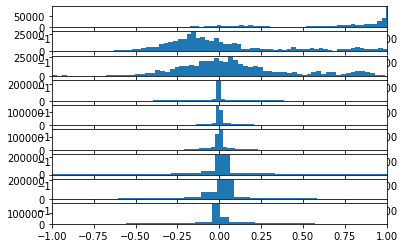

In [185]:
plot_variable_distributions(trainX)

The order of the plots matches the order in which the data was loaded, specifically:

1. Total Acceleration x
2. Total Acceleration y
3. Total Acceleration z
4. Body Acceleration x
5. Body Acceleration y
6. Body Acceleration z
7. Body Gyroscope x
8. Body Gyroscope y
9. Body Gyroscope z

In [190]:
from sklearn.preprocessing import StandardScaler
# standardize data
def scale_data(trainX, testX, standardize):
    # remove overlap
    cut = int(trainX.shape[1] / 2)
    longX = trainX[:, -cut:, :]
    # flatten windows
    longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
    # flatten train and test
    flatTrainX = trainX.reshape((trainX.shape[0] * trainX.shape[1], trainX.shape[2]))
    flatTestX = testX.reshape((testX.shape[0] * testX.shape[1], testX.shape[2]))
    # standardize
    if standardize:
        s = StandardScaler()
        # fit on training data
        s.fit(longX)
        # apply to training and test data
        longX = s.transform(longX)
        flatTrainX = s.transform(flatTrainX)
        flatTestX = s.transform(flatTestX)
    # reshape
    flatTrainX = flatTrainX.reshape((trainX.shape))
    flatTestX = flatTestX.reshape((testX.shape))
    return flatTrainX, flatTestX

What is the differnce between fit and transform?
see this useful article :
https://datascience.stackexchange.com/questions/12321/difference-between-fit-and-fit-transform-in-scikit-learn-models

In [195]:
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy, param):
    verbose, epochs, batch_size = 0, 10, 32
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    # scale data
    trainX, testX = scale_data(trainX, testX, param)
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    return accuracy

In [196]:
# run an experiment
def run_experiment(params, repeats=10):
    # load data
    trainX, trainy, testX, testy = load_dataset()
    # test each parameter
    all_scores = list()
    for p in params:
        # repeat experiment
        scores = list()
        for r in range(repeats):
            score = evaluate_model(trainX, trainy, testX, testy, p)
            score = score * 100.0
            print('>p=%d #%d: %.3f' % (p, r+1, score))
            scores.append(score)
        all_scores.append(scores)
    # summarize results
    summarize_results(all_scores, params)

In [197]:
# summarize scores
def summarize_results(scores, params):
    print(scores, params)
    # summarize mean and standard deviation
    for i in range(len(scores)):
        m, s = mean(scores[i]), std(scores[i])
        print('Param=%d: %.3f%% (+/-%.3f)' % (params[i], m, s))
    # boxplot of scores
    pyplot.boxplot(scores, labels=params)
    pyplot.savefig('exp_cnn_standardize.png')

In [199]:
run_experiment([False, True],10)

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)
>p=0 #1: 90.601
>p=0 #2: 91.076
>p=0 #3: 90.092
>p=0 #4: 90.499
>p=0 #5: 89.311
>p=0 #6: 91.449
>p=0 #7: 89.922
>p=0 #8: 90.329
>p=0 #9: 91.008
>p=0 #10: 90.465
>p=1 #1: 91.856
>p=1 #2: 91.415
>p=1 #3: 92.026
>p=1 #4: 91.415
>p=1 #5: 92.806
>p=1 #6: 91.585
>p=1 #7: 90.227
>p=1 #8: 90.804
>p=1 #9: 91.381
>p=1 #10: 91.686
[[90.60061079063453, 91.07567017305735, 90.09161859518154, 90.49881235154395, 89.31116389548693, 91.44893111638956, 89.92195453003053, 90.32914828639295, 91.00780454699695, 90.46487953851374], [91.85612487275195, 91.41499830335935, 92.02578893790296, 91.41499830335935, 92.80624363759755, 91.58466236851035, 90.22734984730234, 90.80420766881574, 91.38106549032915, 91.68646080760095]] [False, True]


NameError: name 'mean' is not defined